# Knowledge graph embedding

In [102]:
import numpy as np
import pandas as pd
from zlib import adler32
from tqdm.notebook import tqdm, trange
pd.options.display.max_colwidth = 100
import requests

### 1. Freebase dataset 

In this assignment we will see how to use the [TorchKGE](https://github.com/torchkge-team/torchkge) library for building knowledge graphs and its embeddings. To begin with we are going to need a knowledge graph, so let us load a standard knowledge graph dataset called _Freebase-15k-237_.

In [103]:
df = pd.read_csv(
    "https://raw.githubusercontent.com/netspractice/network-science/main/datasets/freebase-237-merged-and-remapped.csv.gz",
    names=['h', 'r', 't'])

In [104]:
df = df[~df.h.str.startswith('/') & ~df.t.str.startswith('/')]
df[::1000].head(10)

,h,r,t
0,"queens college, city university of new york",/education/educational_institution/students_graduates./education/education/student,carol leifer
1103,sharon stone,/award/award_nominee/award_nominations./award/award_nomination/award_nominee,jacob vargas
2210,japan,/location/country/capital,tokyo
3329,syphilis,/medicine/disease/risk_factors,male
4447,michael carlisle hall,/award/award_nominee/award_nominations./award/award_nomination/award_nominee,mena suvari
5555,alice in wonderland,/film/film/language,english language
6653,nauru,/location/country/official_language,english language
7743,ben harper,/people/person/spouse_s./people/marriage/type_of_union,marriage
8840,the perks of being a wallflower,/film/film/country,united states of america
9960,vice president,/business/job_title/people_with_this_title./business/employment_tenure/company,scripps howard broadcasting


There is h — head (also subject), r — relation (also predicat, label), t — tail (also object). The shape of the dataset is

In [105]:
df.shape

(282560, 3)

Let us check the number of unique entities and unique relations.

Write a funtion `n_ent_rel` that takes a dataset and returns a number of unique entities and unique relations.


In [106]:
def n_ent_rel(df):
    # YOUR CODE HERE
    #raise NotImplementedError()
    n_ent = len(set(df['h']).union(set(df['t'])))
    n_rel = df['r'].nunique()
    return n_ent, n_rel

In [107]:
n_ent, n_rel = n_ent_rel(df)
assert adler32(str(n_ent + n_ent).encode()) == 50266365
n_ent, n_rel

(13506, 228)

We can look at all facts about any entity via pandas API

In [108]:
df[df.h ==  'aleksandr pushkin'].head()

,h,r,t
4107,aleksandr pushkin,/people/person/profession,poet
14992,aleksandr pushkin,/influence/influence_node/influenced_by,johann wolfgang von goethe
19525,aleksandr pushkin,/people/person/nationality,russian empire
40237,aleksandr pushkin,/people/person/place_of_birth,moscow
47411,aleksandr pushkin,/influence/influence_node/influenced_by,william shakespeare


In [109]:
df[(df.h ==  'aleksandr pushkin') & (df.t == 'nikolai gogol')]

,h,r,t
145219,aleksandr pushkin,/influence/influence_node/peers./influence/peer_relationship/peers,nikolai gogol


In [110]:
df[(df.h ==  'nikolai gogol') & (df.t == 'aleksandr pushkin')]

,h,r,t
86362,nikolai gogol,/influence/influence_node/peers./influence/peer_relationship/peers,aleksandr pushkin
269512,nikolai gogol,/influence/influence_node/influenced_by,aleksandr pushkin


Let us try to find some facts in this dataset. For example, what is Harrison Ford's nationality? ("harrison ford" in the dataset)

Write a function `harrison_ford_nationality` that takes a dataset and returns the nationality.

_Hint: use `pandas.Series.str.contains` method_

In [111]:
def harrison_ford_nationality(df):
    # YOUR CODE HERE
    #raise NotImplementedError()
    res = df[(df.h ==  'harrison ford') & (df.r.str.contains('nationality'))].iloc[0]['t']
    return res

In [112]:
assert adler32(harrison_ford_nationality(df).encode()) == 1948191013
harrison_ford_nationality(df)

'united states of america'

More tricky question: who are film directors of movies where Harrison Ford was?

Write a function `made_films_with_harrison_ford` that returns a set of directors' names.

In [113]:
def made_films_with_harrison_ford(df):
    # YOUR CODE HERE
    #raise NotImplementedError()
    films = df[(df.h ==  'harrison ford') & (df.r.str.contains('/film/actor/film./film/performance/film'))]['t'].values
    directors = df[(df.t.isin(films)) & (df.r.str.contains('director'))]['h'].values
    return set(directors)

In [114]:
directors = made_films_with_harrison_ford(df)
assert adler32(str(sorted(directors)).encode()) == 3798415057
directors

{'francis ford coppola',
 'george lucas',
 'jon favreau filmography',
 'kathryn bigelow',
 'mike nichols',
 'ridley scott',
 'robert zemeckis',
 'steven spielberg'}

### 2. Translation models 

TransE (translations in the embedding space) is a method which models relationships by interpreting them as translations operating on the low-dimensional embeddings of the entities.

Let us implement the model using TorchKGE — a Python module for knowledge graph embedding relying solely on Pytorch.

In [115]:
!pip install torchkge==0.16.25 -q

In [116]:
import torch
from torch import nn
import torch.nn.functional as F
from torchkge import KnowledgeGraph
from torchkge.utils import Trainer
from torchkge.evaluation import LinkPredictionEvaluator
from torchkge.models.interfaces import TranslationModel
from torch.nn.init import xavier_uniform_

<img src='https://github.com/netspractice/ml-on-graphs/raw/main/assignment_knowledge_graph_embedding/kge.png' width=300>

The basic idea behind the model is that the functional relation induced by the $r$-labeled edges corresponds to a translation of the embeddings, i.e. we want that $h + r \approx t$ when ($h$, $r$, $t$) holds ($t$ should be a nearest neighbor of $h + r$), while $h + r$ should be far away from $t$ otherwise. Thereby, TransE scoring function is negative distance between $h+r$ and $t$

$$f(h, r, t) = -||h + r - t||$$

where $||\cdot||$ is L1 or L2 norm. The goal of the optimization procedure is learning optimal embeddings, such that the scoring function is able to assign high scores to positive statements and low scores to statements unlikely to be true. The most common loss function is Margin Loss that can be represented as

$$L = \text{ReLU}\left(\gamma - f(h, r, t) + f(h', r, t')\right)$$

where $\gamma > 0$ is a "margin" hyperparameter, the triplet $(h, r, t)$ is in a training set (positive) and the $(h', r, t')$ is in a set of *corrupted* (negative) triplets, that are composed of training triplets with either the head or tail replaced by a random entity (but not both at the same time).

We will use TorchKGE TranslationModel as a base for TransE class, here are some auxiliary methods:

* `normalize_parameters` applies `L2` normalization for training stability
* `get_embeddings` returns the tensors representing entities and relations
* `lp_prep_cands` gets entities and relations embeddings for link prediction training process
* `forward` returns scores for positive triplets (`h`, `r`, `t`) and negative triplets (`nh`, `r`, `nt`)

In [117]:
class BaseTransE(TranslationModel):
    def __init__(self, num_entities, num_relations, dim=100):
        super(BaseTransE, self).__init__(num_entities, num_relations, dissimilarity_type='L2')
        self.num_entities = num_entities
        self.num_relations = num_relations
        self.dim = dim
        self.ent_embeddings = nn.Embedding(num_entities, self.dim)
        self.rel_embeddings = nn.Embedding(num_relations, self.dim)

    def normalize_parameters(self):
        self.ent_embeddings.weight.data = F.normalize(self.ent_embeddings.weight.data, p=2, dim=1)

    def get_embeddings(self):
        self.normalize_parameters()
        return self.ent_embeddings.weight.data, self.rel_embeddings.weight.data

    def lp_prep_cands(self, h_idx, t_idx, r_idx):
        b_size = h_idx.shape[0]

        h_emb = self.ent_embeddings(h_idx)
        t_emb = self.ent_embeddings(t_idx)
        r_emb = self.rel_embeddings(r_idx)

        candidates = self.ent_embeddings.weight.data.view(1, self.num_entities, self.dim)
        candidates = candidates.expand(b_size, self.num_entities, self.dim)

        return h_emb, t_emb, candidates, r_emb

    def forward(self, h, t, nh, nt, r):
        return self.scoring_function(h, t, r), self.scoring_function(nh, nt, r)

Write a function `scoring_function` that takes a tensor `h`, `t`, `r` with triplets of the shape (number of triplets) and returns its L2 scores. For training stability, apply L2 normalization (`F.normalize`  with `p=2`) on entities embeddings before computing the scores. Note that `h`, `t`, `r` are tensors with integer IDs of entities and relations.

In [118]:
class TransE(BaseTransE):
    def scoring_function(self, h, t, r):
        # YOUR CODE HERE
        #raise NotImplementedError()
        h_emb = self.ent_embeddings(h)
        t_emb = self.ent_embeddings(t)
        r_emb = self.rel_embeddings(r)

        h_emb = F.normalize(h_emb, p=2, dim=1)
        t_emb = F.normalize(t_emb, p=2, dim=1)

        return - torch.norm(h_emb + r_emb - t_emb, p=2, dim=1)

In [119]:
model = TransE(num_entities=5, num_relations=2, dim=2)

h = torch.LongTensor([1, 1, 1])
r = torch.LongTensor([0, 1, 1])
t = torch.LongTensor([2, 2, 3])

with torch.no_grad():
    scores = model.scoring_function(h, t, r).numpy()
assert scores.shape == (3, ) # 3 triplets

Complete the class `MarginLoss` so that computes the losses among scores and returns an average loss. Positive and negative scores are tensors of the shape (number of triplets).

In [120]:
class MarginLoss(nn.Module):
    def __init__(self, margin):
        super().__init__()
        self.margin = margin
    def forward(self, positive_scores, negative_scores):
        # YOUR CODE HERE
        #raise NotImplementedError()
        return F.relu(self.margin - positive_scores + negative_scores).mean()

In [121]:
loss_fn = MarginLoss(margin=0.5)
torch.manual_seed(0)
positive_scores = torch.randn(8)
negative_scores = torch.randn(8)
loss = loss_fn(positive_scores, negative_scores)
assert loss.shape == torch.Size([])
assert round(loss.item(), 2) == 0.79

Let us look at the WikiDataSet that presents country-specific subgraphs of Wikidata.

In [122]:
url = 'https://raw.githubusercontent.com/netspractice/network-science/main/datasets/countries_edges.tsv'
open('countries_edges.tsv', 'wb').write(requests.get(url).content)
url = 'https://raw.githubusercontent.com/netspractice/network-science/main/datasets/countries_entities.tsv'
open('countries_entities.tsv', 'wb').write(requests.get(url).content)
url = 'https://raw.githubusercontent.com/netspractice/network-science/main/datasets/countries_relations.tsv'
open('countries_relations.tsv', 'wb').write(requests.get(url).content);

In [123]:
edges = pd.read_csv('countries_edges.tsv', sep='\t').values
entity_labels = pd.read_csv('countries_entities.tsv', sep='\t', index_col=0, engine='python').label.values
relation_labels = pd.read_csv('countries_relations.tsv', sep='\t', index_col=0).label.values

In [124]:
edges_labeled = np.stack([entity_labels[edges[:, 0]],
                          entity_labels[edges[:, 1]],
                          relation_labels[edges[:, 2]]], axis=1)

df = pd.DataFrame(edges_labeled, columns=['h', 't', 'r'])[['h', 'r', 't']]
df.head()

,h,r,t
0,Belgium,country,Belgium
1,Belgium,diplomatic relation,Luxembourg
2,Belgium,diplomatic relation,Italy
3,Belgium,diplomatic relation,Germany
4,Belgium,diplomatic relation,Liechtenstein


Here are unique relations with the number of triplets

In [125]:
df.r.groupby(df.r).count()

,r
r,
applies to jurisdiction,1
basic form of government,3
biological process,1
capital,34
capital of,25
contains administrative territorial entity,94
country,1339
country of citizenship,5
country of origin,1


Convert our dataset into a TorchKGE knowledge graph

In [126]:
kg = KnowledgeGraph(
    pd.DataFrame(edges_labeled, columns=['from', 'to', 'rel']))

In [127]:
kg

Split the dataset into train and test set. What differs from the standard method of randomly sampling N points to make up our test set, is that our data points are two entities linked by some relationship, and we need to take care to ensure that all entities are represented in train and test sets by at least one triple.



In [128]:
kg_train, kg_test = kg.split_kg()

Create required objects: model, loss, optimizer and trainer.

In [129]:
model = TransE(kg_train.n_ent, kg_train.n_rel, dim=64)
criterion = MarginLoss(margin=0.5)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

trainer = Trainer(
    model, criterion, kg_train, n_epochs=500,
    batch_size=2048, optimizer=optimizer)

During training, positive triplets are selected, negative triplets are generated, margin loss is calculated and then the gradient step is performed.

In [130]:
trainer.run()

  0%|          | 0/500 [00:00<?, ?epoch/s]

Let us evaluate our model on the link prediction task

In [131]:
evaluator = LinkPredictionEvaluator(model, kg_test)
evaluator.evaluate(b_size=128)

assert evaluator.hit_at_k(k=10)[0] > 0.3
assert evaluator.mean_rank()[0] < 70
assert evaluator.mrr()[0] > 0.1

Link prediction evaluation:   0%|          | 0/17 [00:00<?, ?batch/s]

In [132]:
print('Hit@10: {:.4f}'.format(evaluator.hit_at_k(k=10)[0]))
print('Mean Rank: {:.4f}'.format(evaluator.mean_rank()[0]))
print('MRR: {:.4f}'.format(evaluator.mrr()[0]))

Hit@10: 0.3337
Mean Rank: 67.2574
MRR: 0.1400


`Hit@k` indicates how many times in average a true triple was ranked in the top-k.

`Mean Rank` is a mean rank of the true entity when replacing alternatively head and tail in any fact of the dataset.

`MRR` is an average of mean recovery rank for head and tail replacement.

### 3. Entity embeddings

In [133]:
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import k_means
import matplotlib.pyplot as plt

Similarly to node embedding visualization, we can plot 2D embeddings of entities of knowledge graph.

Write a function `ent_embeddgins` that takes the model, transforms entity embeddings into 2-dimenstional space via SVD, then finds 2 clusters via k-means and finally returns a tuple: np.array with embeddings and 0/1 labels of clusters.

In [134]:
def ent_embeddgins(model):
    embeddings_2d = TruncatedSVD(
        n_components=2, random_state=42
    ).fit_transform(model.get_embeddings()[0].cpu().numpy())

    _, cluster_assignments, _ = k_means(
        embeddings_2d, n_clusters=2, n_init='auto', random_state=42
    )

    return embeddings_2d, cluster_assignments

In [135]:
ent_emb, labels = ent_embeddgins(model)
assert ent_emb.shape == (1810, 2)
assert labels.shape == (1810,)
n_label1 = (labels == 1).sum()
n_label0 = (labels == 0).sum()
assert 0.14 < min(n_label1, n_label0) / max(n_label1, n_label0) < 0.18

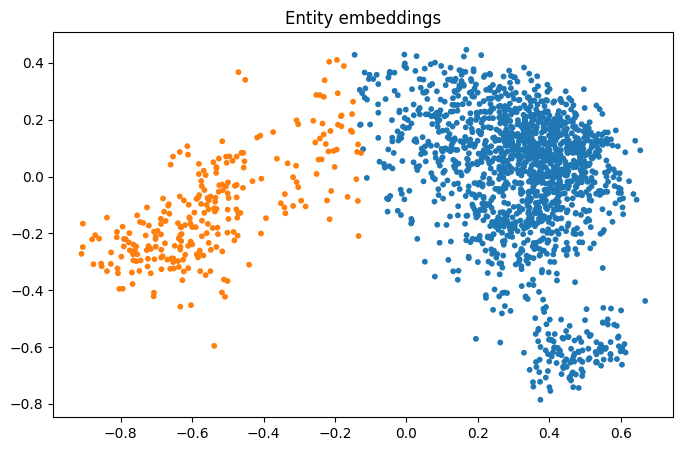

In [136]:
plt.figure(figsize=(8, 5))
colors = np.array(plt.cm.tab10.colors)
plt.scatter(ent_emb[:, 0], ent_emb[:, 1], s=10, c=colors[labels])
plt.title('Entity embeddings')
plt.show()

Let us look at some randomly chosen entities from each cluster. Here we use `kg.ent2ix` dictionary to get labels of entities.

In [137]:
ent_labels = np.array(list(kg.ent2ix.keys()))
print('First cluster: ', ', '.join(
    np.random.permutation(ent_labels[labels == 0])[:10]))
print()
print('Second cluster: ', ', '.join(
    np.random.permutation(ent_labels[labels == 1])[:10]))

First cluster:  Jinhan confederacy, Slovak People's Republic, Repubblica partigiana del Corniolo, estat del Nil, Principality of Dukagjini, Zazzau, First Saudi State, Kingdom of the Hwicce, Columbia District, Gilzanu

Second cluster:  Panama, Cameroon, Second Polish Republic, Cape Verde, Socialist Federal Republic of Yugoslavia, Confederate States of America, Vatican City, Saar, Donetsk People's Republic, Armenia


### 4. Nearest neighbors of entities

In [138]:
from sklearn.neighbors import NearestNeighbors

Let us find a nearest neighbors of Belgium using embedding space.

Write a function `similar_countries` that takes a name of country, graph and model and returns a list with names of nearest countries. Use `model.get_embeddings()`.

In [139]:
def similar_countries(name, kg, model):
    all_ent_vecs = model.get_embeddings()[0].cpu().numpy()

    neighbor_finder = NearestNeighbors(n_neighbors=6, metric='cosine').fit(all_ent_vecs)
    target_idx = kg.ent2ix[name]
    _, neighbor_indices = neighbor_finder.kneighbors(all_ent_vecs[target_idx:target_idx+1])

    id_to_name_map = {v: k for k, v in kg.ent2ix.items()}
    return [id_to_name_map[idx] for idx in neighbor_indices.flatten()[1:]]

In [140]:
similar = similar_countries('Belgium', kg, model)
assert 'Netherlands' in similar
similar

['Netherlands',
 'Luxembourg',
 'France',
 'Kingdom of the Netherlands',
 'Switzerland']

### 5. Relation prediction

Let us consider these facts:
1. Belgium shares border with France
2. Belgium shares border with Switzerland
3. Belgium shares border with Nigeria

Only the fact 1 is truth, but it seems that the fact 2 is more likely than 3.

In [141]:
df[(df.h == 'Belgium') & (df.t == 'France')]

,h,r,t
8,Belgium,diplomatic relation,France
32,Belgium,shares border with,France


In [142]:
df[(df.h == 'Belgium') & (df.t == 'Switzerland')]

,h,r,t


In [143]:
df[(df.h == 'Belgium') & (df.t == 'Nigeria')]

,h,r,t


Now we can compare these facts using scoring function of TransE model to check our prior knowledge.

Write a function `belgium_facts` that takes a model, a graph and returns 3 values of scoring function for each fact. Use `model.scoring_function` with `torch.no_grad()`.

In [144]:
def belgium_facts(model, kg):
    head_entity = 'Belgium'
    relation_type = 'shares border with'
    tail_entities = ['France', 'Switzerland', 'Nigeria']

    h_idx = torch.LongTensor([kg.ent2ix[head_entity]] * len(tail_entities))
    r_idx = torch.LongTensor([kg.rel2ix[relation_type]] * len(tail_entities))
    t_indices = torch.LongTensor([kg.ent2ix[t] for t in tail_entities])

    with torch.no_grad():
        fact_scores = model.scoring_function(h_idx, t_indices, r_idx)

    return fact_scores.cpu().numpy()

In [145]:
scores = belgium_facts(model, kg)
assert scores[0] > scores[1] > scores[2]
scores

array([-0.6062758 , -0.69949275, -0.99749863], dtype=float32)

### 6. Tail prediction

In [146]:
from sklearn.neighbors import NearestNeighbors

Recall that the main idea of TransE is to learn $h + r \approx t$, so let us find the closest tails for the head + relation pair.

Write a function `soviet_tail` that takes a model, graph and finds 5 nearest neighbors for the pair $h$ is "Soviet Union" and $r$ is "founded by".

In [147]:
def soviet_tail(model, kg):
    ent_vecs, rel_vecs = [data.cpu().numpy() for data in model.get_embeddings()]

    head_vector = ent_vecs[kg.ent2ix['Soviet Union']]
    relation_vector = rel_vecs[kg.rel2ix['founded by']]
    projected_tail_vec = (head_vector + relation_vector).reshape(1, -1)

    nn_search = NearestNeighbors(n_neighbors=5, metric='euclidean').fit(ent_vecs)
    _, top_indices = nn_search.kneighbors(projected_tail_vec)

    idx_to_entity_map = {idx: name for name, idx in kg.ent2ix.items()}
    return [idx_to_entity_map[i] for i in top_indices.flatten()]

In [148]:
tails = soviet_tail(model, kg)
assert 'Russian Soviet Federative Socialist Republic' in tails
tails

['Soviet Union',
 'Transcaucasian Socialist Federative Soviet Republic',
 'Russian Empire',
 'Russian Soviet Federative Socialist Republic',
 'Russian Republic']